In [34]:
import menpo3d.io as m3dio
import menpo.io as mio
import menpo3d
import numpy as np
import mappings

from io import BytesIO
from scipy.io import loadmat, savemat
from functools import reduce
from pathlib import Path

from menpo.image import Image, MaskedImage
from menpo.transform import AlignmentSimilarity
from menpo.shape import PointCloud, TriMesh, ColouredTriMesh, TexturedTriMesh
from menpo.visualize import print_progress

np.set_printoptions(precision=3, suppress=True)

In [2]:
root_dir = Path('/homes/gt108/Projects/ibugface/data/photoface')

In [148]:
for path in (root_dir / 'albedo').glob('4*.png'):
    image = mio.import_image(path)
    nrm_path = path.parent.parent / 'normals' / path.with_suffix('.mat').name
    
    mat = loadmat(nrm_path.as_posix())
    
    image = MaskedImage(image.pixels, mask=mat['cert'])
    nrm = MaskedImage.init_from_channels_at_back(mat['norms'] * np.array([-1, 1, 1]), mask=mat['cert'])
    break

/vol/atlas/homes/gt108/Projects/menpo/menpo/image/boolean.py:112: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '


In [92]:
def crop_face(img, boundary=30, group=None, shape=(386, 386), order=1):
    min_indices, max_indices = img.mask.bounds_true(boundary=boundary)
    h = max_indices[0] - min_indices[0]
    w = max_indices[1] - min_indices[1]
    pad = abs(w - h)

    try:
        index = 1 - int(w > h)
        min_indices[index] -= int(pad / 2.)
        max_indices[index] += int(pad / 2.) + int(pad) % 2

        img = img.crop(min_indices, max_indices, constrain_to_boundary=True)
    except Exception as e:
        print("Exception in crop_face", e)

    img = img.resize(shape, order=order)
    return img

In [126]:
def normalise(nrm):
    nrm = nrm.copy()
    nrm.pixels += 1
    nrm.pixels /= 2
    return nrm

In [139]:
nrm.masked_pixels()[0].mean()

-0.049843891338374809

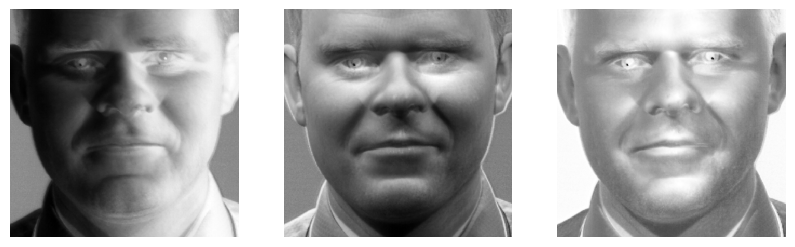

In [130]:

normalise(nrm).as_unmasked().view(channels='all')

In [102]:
def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_jpg_string(im):
    '''Serializes an `Image` to bytes.'''
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def serialize_sample(image, normals):
    height, width = image.shape
    
    example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int_feauture(height),
                'width': _int_feauture(width),
                'image': _bytes_feauture(get_jpg_string(image)),
                'normals': _bytes_feauture(normals.pixels_with_channels_at_back().astype(np.float32).tobytes())
    }))
    
    return example

In [140]:
import tensorflow as tf

In [215]:
path = '/vol/atlas/databases/tf_records/photoface_600x600.tfrecords'
writer = tf.python_io.TFRecordWriter(path)

In [214]:
image_shape = (600, 600)

In [213]:
for path in print_progress(list((root_dir / 'albedo').glob('*.png'))):
    image = mio.import_image(path)
    nrm_path = path.parent.parent / 'normals' / path.with_suffix('.mat').name
    
    mat = loadmat(nrm_path.as_posix())
    try:
        image = (MaskedImage(image.pixels, mask=mat['cert']))
        nrm = (MaskedImage.init_from_channels_at_back(mat['norms'] * np.array([-1, 1, 1]), mask=mat['cert']))
    
        example = serialize_sample(crop_face(image, shape=image_shape).as_unmasked(), crop_face(nrm, order=0, , shape=image_shape))
        writer.write(example.SerializeToString())
    except ValueError:
        pass
writer.close()

[                    ] 0% (2/3152) - 00:03:53 remaining                         

/vol/atlas/homes/gt108/Projects/menpo/menpo/image/boolean.py:112: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '


[====================] 100% (3152/3152) - done.                                 
